<a href="https://colab.research.google.com/github/BorjaRequena/ML-for-quantum-and-classical-systems/blob/main/1%20Deep%20learning%20for%20computer%20vision%20/neural_network_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Deep neural networks and deep convolutional neural networks</h1>


---


**Alexandre Dauphin and Gabriel Fernández Fernández**

## Import the Libraries 

In [ ]:
# import numpy and matplotlib
import numpy as np
from matplotlib import pyplot as plt

# install fastai on colab
! [ -e /content ] && pip install -Uqq fastai 
from fastai.vision.all import * 
from fastai.vision.widgets import *
from fastprogress.fastprogress import master_bar, progress_bar

# pytorch
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

# pytorch summary
!pip install -Uqq torchinfo
from torchinfo import summary

# import typing
from typing import Dict, Iterable, Callable

# scikit learn
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# random library
import random

# miscellaneous
from collections import Counter

     |████████████████████████████████| 189 kB 8.5 MB/s 
     |████████████████████████████████| 56 kB 6.3 MB/s 


## Link the colab file to your google drive

---

By executing the next cell, we will be able to access and write data on the google drive

In [ ]:
# link the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## GPU

---


In colab, you can choose the hardware your code will be running on. For neural networks, running the code on GPUs is highly recommended as it allows for massive parallelisation.
Usually, GPUs provide ~10x speedup compared to the CPU.
Thus, make sure GPU is enabled with the following steps:

*   Go to Edit
*   Select Notebook settings
*   In Hardware accelerator, choose GPU

Once done the first time, colab remembers the option.



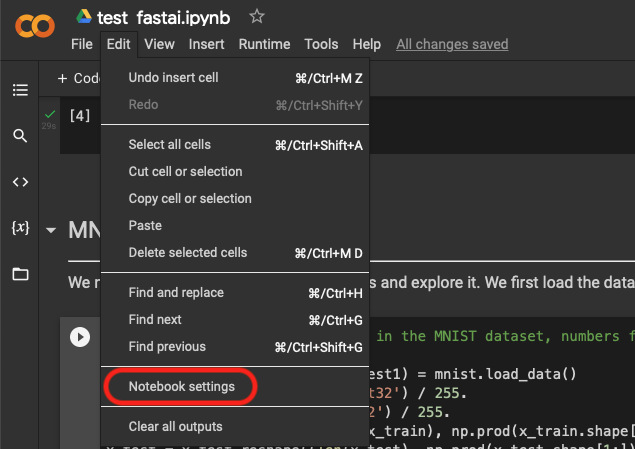
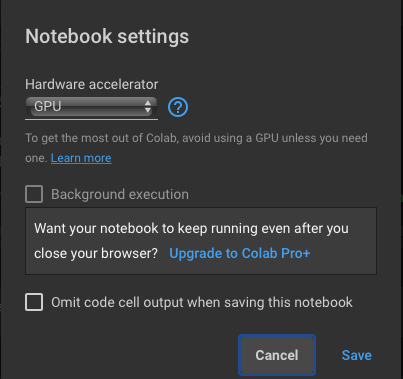

## MNIST dataset with fastai
---


We now import the MNIST hanwritten digits with fastai.

fastai has a compilation of urls linked to different datasets. For example, the MNIST dataset can be accessed through `URLs.MNIST`.

In [ ]:
URLs.MNIST

'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz'

We then use the untar_data function to download locally the data

In [ ]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

Data are now stored in `~/.fastai/data/mnist_png/` and are split in a training and a test folder. In each of these foders, the numbers are separated by folder, going from 0 to 9.

In [ ]:
!ls ~/.fastai/data/mnist_png/

testing  training


In [ ]:
Image.open((path/"training/1").ls()[0])

We then plot them with their associated labels. The dataset is stored in the folder `path/'training'/`. In this folder, each number is stored in a separate folder. 

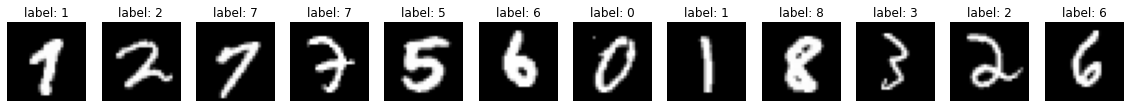

In [ ]:
# We take 12 examples in the training set
nexample = 12

fig, axes = plt.subplots(nrows=1,ncols=nexample,figsize=(20,20))

for i, ax in enumerate(axes.flat):
  n = np.random.randint(9)
  list_path = (path/'training'/f'{n}').ls()
  im = Image.open(random.choice(list_path))
  ax.imshow(im,cmap='gray')
  ax.set_title(f'label: {n}')
  ax.axis('off');

## PCA analysis on RAW data
---


We first perform a PCA analysis on the raw data. This data analysis will allow us to understand a bit better how structured is the dataset.

The first step is to load the dataset. 

We then read all the images. These are images of 28x28 pixels, which we flatten as PCA is working on vectors.

In [ ]:
n_classes = 10 # number of classes in the MNIST dataset, numbers from 0 to 9
list_path, y_train = [], []
for i in range(n_classes):
  liste = list((path/'training'/f'{i}').ls())
  list_path = list_path + liste
  y_train = y_train + [i]*len(liste)

c = list(zip(list_path, y_train))
random.shuffle(c)
list_path, y_train = zip(*c)

x_train = []
for p in progress_bar(list_path):
  im = Image.open(p)
  x_train.append(np.array(im).flatten())

x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
def plot_confusion_matrix(y_pred,y_train,n_classes=10,cmap='Blues',ax=None):
  # adapted from the fastai library
  if ax is None: fig,ax = plt.subplots(1)

  cm = confusion_matrix(y_train,y_pred)
  ax.imshow(cm,interpolation='nearest', cmap=cmap)

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    thresh = cm.max() / 2.
    coeff = f'{cm[i, j]}'
    ax.text(j, i, coeff, horizontalalignment="center", 
            verticalalignment="center", 
            color="white" if cm[i, j] > thresh else "black")
  ax.set_xticks(np.arange(n_classes))
  ax.set_yticks(np.arange(n_classes))
  ax.set_ylabel('Actual')
  ax.set_xlabel('Predicted')
  ax.set_title('Confusion Matrix')

def plot_PCA(x_train, y_train, figsize=(12,4), n_classes=10,eigv=False, **kwargs):
  pca = PCA(n_components=2)
  x_original=pca.fit_transform(x_train)

  kmeans=KMeans(n_clusters=n_classes)
  kmeans.fit(x_train)
  y_pred=kmeans.predict(x_train)

  fig, axes = plt.subplots(nrows=1, ncols=3,figsize=figsize)

  ax=axes[0]
  im1=ax.scatter(x_original[:,0],x_original[:,1],c=y_train,cmap='tab10')
  ax.set_title('PCA with training labels')

  ax=axes[1]
  im2=ax.scatter(x_original[:,0],x_original[:,1],c=y_pred,cmap='tab10')
  ax.set_title('k_means predicition')

  plot_confusion_matrix(y_pred,y_train,ax=axes[2],n_classes=n_classes, **kwargs)

  fig.tight_layout() 
  fig.colorbar(im2,ax=axes.ravel().tolist()[:2]);
  if eigv: return pca.components_

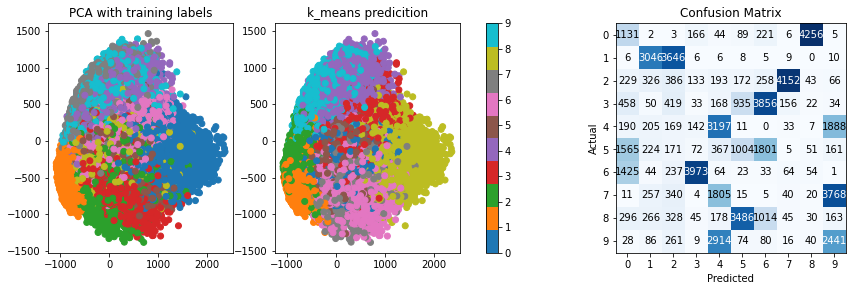

In [ ]:
plot_PCA(x_train, y_train) # ~2 min.

As we see in the left plot, the data do not cluster nicely. 
We also perform a cluster classifcation with k-means. 
Here, the idea is to let the unsupervised algorithm find 10 clusters on the raw data. 
We then associate a number to each cluster. 
To be able to compare these results with the other figure, we look at the confusion matrix, which compares the actual labels with the predicted labels (here predicted by kmeans). 
We can directly see that there is no direct correpondence between the true labels and the ones predicted by kmeans, which higlights that there is no direct clustering of the raw data.

**Homework** 


1.   Plot the first and second eigenvectors of the PCA analysis. What do you see? [*Tip:* You can extract the eigenvectors from the `plot_PCA` function by setting `eigv=True`. Don't forget to reshape the vector in the form of an image]
2.   Run the unsupervised algorithm t-SNE on the data and compare with the results of PCA. Is there some interesting structure in the raw data?





##Dataloader
---

We now define a dataloader. 
A dataloader is a class that allows the user to load easily the data to the GPU when training a model. 
We will not enter into the details on how to construct the loader. 
The loader also allows us to split the data between the training and the validation sets.

In [ ]:
block = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label)

Once the dataloader is defined, you can give it a path to a folder with images and it will automatically create batches.

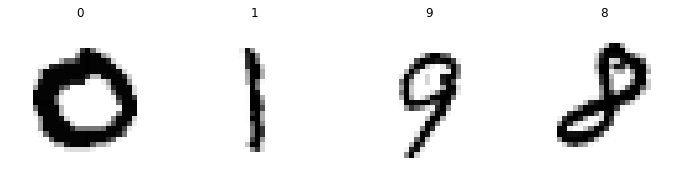

In [ ]:
loaders = block.dataloaders(path/"training")
loaders.train.show_batch(max_n=4, nrows=1)

##Fully connected neural network
---
We first create a class containing a fully connected neural network. As the images coming from the dataloader have three channels, we select one channel and flatten the image to a vector before applying a fully neural network.

In [ ]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(784, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 10, bias=True),
            nn.ReLU(),
            nn.Linear(10, 10, bias=True))

    def forward(self, xb):
        x = xb[:,0,:,:] # avoid channel dimension
        x = x.view(-1,784)
        x = self.block1(x)
        return x

### A first training in PyTorch
---


To get a better insight of the different steps of the optimizer, we first train a neural network with PyTorch.

We first define the model, here directly from the class `Mnist_NN()` defined in the previous section.



In [ ]:
fnn = Mnist_NN()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
fnn.to(device)

print(fnn)

Mnist_NN(
  (block1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
  )
)


With the summary, we can see the number of parameters and output shapes of each layer.

In [ ]:
batch_size = 64
summary(fnn, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Mnist_NN                                 --                        --
├─Sequential: 1-1                        [64, 10]                  --
│    └─Linear: 2-1                       [64, 128]                 100,480
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 64]                  8,256
│    └─ReLU: 2-4                         [64, 64]                  --
│    └─Linear: 2-5                       [64, 10]                  650
│    └─ReLU: 2-6                         [64, 10]                  --
│    └─Linear: 2-7                       [64, 10]                  110
Total params: 109,496
Trainable params: 109,496
Non-trainable params: 0
Total mult-adds (M): 7.01
Input size (MB): 0.20
Forward/backward pass size (MB): 0.11
Params size (MB): 0.44
Estimated Total Size (MB): 0.75

Printing the model allows one to see the structure of the latter. We then define the loss function of the model. Here we use the ```CrossEntropyLossFlat()``` of fastai, which is a cross entropy loss but with flattened inputs and outputs.

In [ ]:
loss_func = CrossEntropyLossFlat()
loss_func

FlattenedLoss of CrossEntropyLoss()

We then define the optimizer. For the sake of the example, we here choose ```Adam```, a pretty standard optimizer in machine learning, but you could also try with stochastic gradient descent with momentum. 

In [ ]:
optimizer = Adam(fnn.parameters(),lr=1e-4)  
optimizer

Finally, we define an accuracy function, which will allow us to compare the results of the predictions ````y_pred```` with the real labels ```y```.

In [ ]:
def accuracy_py(y_pred,y): 
  a, b = torch.clone(ypred), torch.clone(y)
  a = a.argmax(dim=1)
  a, b = a.cpu().detach().numpy(),b.cpu().detach().numpy()
  return accuracy_score(a,b)

Let's now define the training loop. For each batch, it consists in a forward pass, which allows us to compute the predicted labels `ypred` and subsequently the loss funcion `loss`. 
Then, we initialize the gradients to zero with `zero_grad()` and compute the gradients with the help of the `backward()` function, which basically performs the backpropagation on the graph. 
Finally, we use the optimizer to update the parameters with `optimizer.step()`.   

We compute the loss function and the accuracy on both the training and validation sets.

In [ ]:
num_epochs = 5 # ~1 min./epoch

mb = master_bar(range(num_epochs))

l,a = torch.ones(num_epochs)*10, torch.ones(num_epochs)*10
l_valid,a_valid = torch.ones(num_epochs)*10, torch.ones(num_epochs)*10

# training loop
for epoch in mb:
  local_a, local_l = [], []
  for i, (x, y) in enumerate(progress_bar(loaders.train, parent=mb)):
    ypred = fnn(x)
    loss = loss_func(ypred,y)
    local_l.append(loss)
    # initialize gradients
    optimizer.zero_grad()
    # computation of the gradients
    loss.backward()
    # update of the parameters
    optimizer.step()
    # computation of the accuracy 
    acc = accuracy_py(ypred,y)
    local_a.append(acc)
  ll, aa = torch.mean(torch.tensor(local_l)), torch.mean(torch.tensor(local_a))
  l[epoch], a[epoch] = ll, aa
  local_a, local_l = [], []
  # validation set
  for i, (x, y) in enumerate(progress_bar(loaders.valid, parent=mb)):
    ypred = fnn(x)
    loss = loss_func(ypred,y)
    local_l.append(loss)
    acc = accuracy_py(ypred,y)
    local_a.append(acc)
  ll, aa = torch.mean(torch.tensor(local_l)), torch.mean(torch.tensor(local_a))
  l_valid[epoch], a_valid[epoch] = ll, aa
  text = f'''Epoch {epoch} --- loss: {l[epoch]:.3f} accuracy: {a[epoch]:.3f} 
                        valid loss: {l_valid[epoch]:.3f} valid accuracy: {a_valid[epoch]:.3f}'''
  mb.write(text)

Hooray !!!
You preformed your first training of a neural network!
Let's have a look at the loss and validation curves.

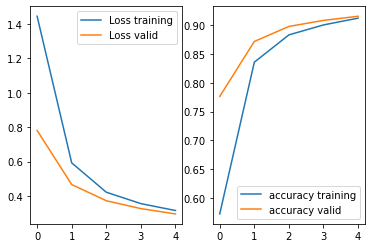

In [ ]:
fig, axes = plt.subplots(1,2)

data = [l,a]
data_valid = [l_valid, a_valid]
title = ['Loss', 'accuracy']
for i,ax in enumerate(axes):
  ax.plot(data[i],label=title[i]+' training')
  ax.plot(data_valid[i], label=title[i]+' valid')
  ax.legend()

### Training with fastai

Let's now have a look at fastai. fastai is much high level library than pytoch. Among others, it allows you to train a model without explicitly writing the training loop.

Fastai has a class called `Learner`, which requires: a loader, a model, and a loss function.

You can also add extra parameters such metrics, which allows you to print the accuracy, or callbacks, which allow you to perform different actions during the training loop.
Here, for example, we define two callbacks: one allows you to plot the loss function during the training and the other allows you to save in a CSV file quantities such as the loss and the accuracy. 

In [ ]:
loss = CrossEntropyLossFlat()
folder_path = '/content/drive/My Drive/fastai/'
# Create folder
os.makedirs(folder_path, exist_ok=True)

log_name = folder_path + 'history_fnn.csv'
fname = folder_path + 'fnn'
callbacks = [ShowGraphCallback(),CSVLogger(fname=log_name,append=True)]
learn = Learner(loaders, Mnist_NN(),loss_func=loss,opt_func=Adam,metrics=accuracy,cbs=callbacks)
learn.model.cuda()

Mnist_NN(
  (block1): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
  )
)

The last line `learn.model.cuda() ` forces the model to be run on GPU.

In fastai, the training loop is hidden under the API.
With the following function we can see it.

In [ ]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, CSVLogger, ShowGraphCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback, ShowGraphCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorde

Training the model is quite easy, you just have to use the `fit` function. Notice that different parameters of the optimizer such as the learning rate are chosen by default in the learner. You can also input them if you prefer (see the documentation of fastai).

epoch,train_loss,valid_loss,accuracy,time
0,0.243172,0.226235,0.935500,00:48
1,0.141755,0.140342,0.958000,00:49
2,0.116032,0.123872,0.965333,00:48
3,0.090288,0.116037,0.967667,00:48
4,0.074863,0.099393,0.971667,00:48
5,0.056158,0.107169,0.970250,00:48
6,0.046119,0.105048,0.971250,00:48
7,0.044857,0.105549,0.972250,00:48
8,0.032922,0.103353,0.972333,00:48
9,0.030478,0.109204,0.973250,00:49


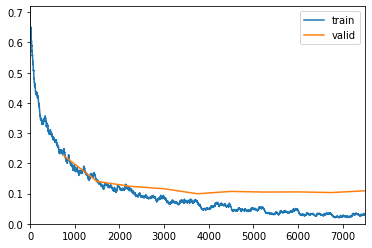

Path('/content/drive/My Drive/fastai/fnn.pth')

In [ ]:
learn.fit(10) #~ 1 min per epoch
learn.save(fname)

`learn.save` saves the state of the learner after training.
You can then load it with the help of `learn.load`.

In [ ]:
learn.load(fname)

Let's have a look at one prediction of the model.

In [ ]:
files = get_image_files(path/"training/")
learn.predict(files[0])

('8',
 TensorImageBW(8),
 TensorImageBW([2.8820e-09, 9.5297e-12, 1.8255e-06, 5.5131e-05, 3.5726e-08, 1.0439e-07,
         1.7958e-10, 4.8086e-11, 9.9992e-01, 2.0796e-05]))

We can alternatively see the predictions and the actual label with `learn.show_results`.

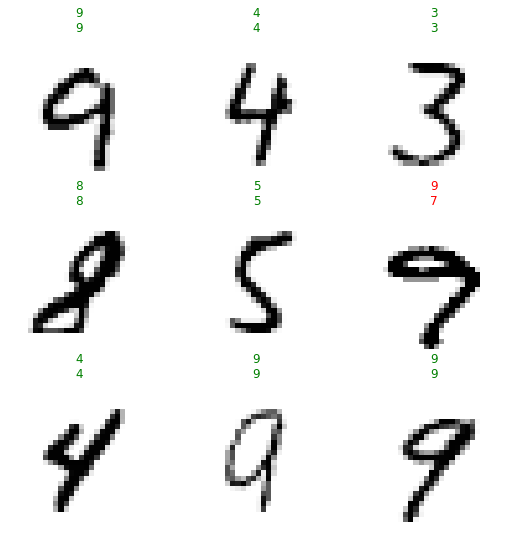

In [ ]:
learn.show_results()

Let's have a look at the log file, which contains interesting informations. Here the accuracy is the accuracy on the validation set.

In [ ]:
df = pd.read_csv(log_name)
df#.head()

,epoch,train_loss,valid_loss,accuracy,time
0,0,0.243172,0.226235,0.935500,00:48
1,1,0.141755,0.140342,0.958000,00:49
2,2,0.116032,0.123872,0.965333,00:48
3,3,0.090288,0.116037,0.967667,00:48
4,4,0.074863,0.099393,0.971667,00:48
5,5,0.056158,0.107169,0.970250,00:48
6,6,0.046119,0.105048,0.971250,00:48
7,7,0.044857,0.105549,0.972250,00:48
8,8,0.032922,0.103353,0.972333,00:48
9,9,0.030478,0.109204,0.973250,00:49


A careful inspection of the Loss function allows us to see a first example of **overfitting**, where the training loss continues to decrease but the accuracy loss reaches a plateau. 

In [ ]:
# error when plotting: TypeError: no numeric data to plot.
# check types
df.dtypes

epoch         float64
train_loss    float64
valid_loss    float64
accuracy      float64
time          float64
dtype: object

In [ ]:
# if they are objects, correct it translating to numeric:
df = df.apply(pd.to_numeric, errors = 'coerce').dropna()
# this happens because csv saving was incorrect 
# probably due to stops in the training
# together with the append mode enabled.

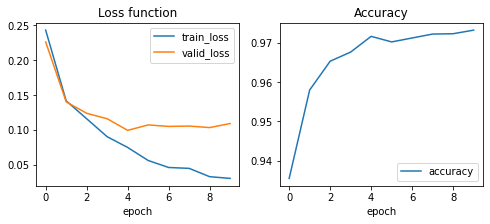

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
df.plot(x='epoch',y=['train_loss','valid_loss'],ax=ax[0])
df.plot(x='epoch',y='accuracy',ax=ax[1])
title = ['Loss function','Accuracy']
for i in range(2):
  ax[i].set_title(title[i])

### Inspection of the trained neural network
---

It is worth to analyse a bit the trained neural network. 
Fastai provides the confusion matrix. 

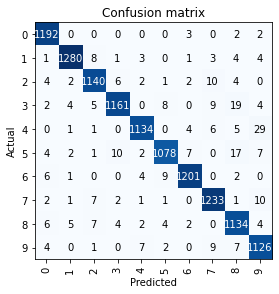

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Alternatively, we can also study the top losses.

In [ ]:
dl = learn.dls[0]
xx = learn.get_preds(dl=dl,with_loss=True,with_input=True) # ~1 min.
input,y_pred,y,label_loss = xx[0],xx[1],xx[2],xx[3]
y_pred = torch.argmax(y_pred,dim=1)
sort_mask = torch.argsort(label_loss)

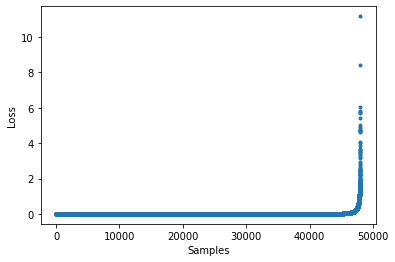

In [ ]:
plt.plot(label_loss[sort_mask],'.');
plt.xlabel('Samples'); plt.ylabel('Loss');

We then plot the top losses along with the image and the predicted and real labels.

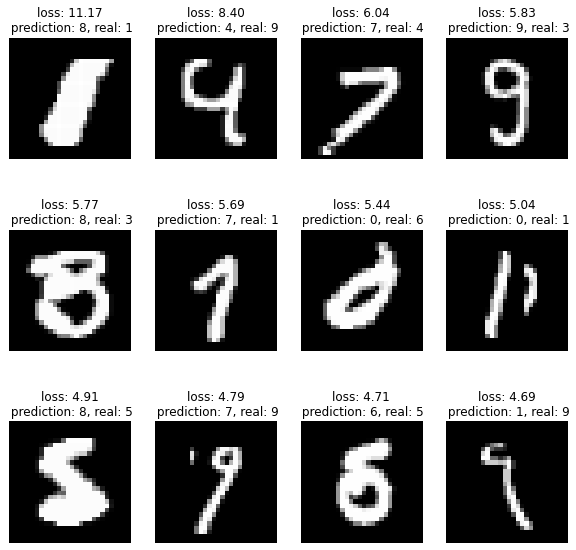

In [ ]:
# We take 12 examples in the training set
nexample = 12

fig,axes = plt.subplots(nrows=int(np.ceil(nexample/4)),ncols=4,figsize=(10,10))

for i,ax in enumerate(axes.flat):
  index = sort_mask[-i-1]
  ax.imshow(input[index][0,:,:],cmap='gray')
  ax.set_title(f'loss: {label_loss[index]:.2f}\n prediction: {y_pred[index]}, real: {y[index]}')
  ax.axis('off')

After training, it might be beneficial to remove from the dataset examples with wrong labels, which generate high losses. Fastai has an API for that: `ImageClassifierCleaner`.

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

### Analysis of the feature space

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            with torch.no_grad():
                self._features[layer_id] = output
        return fn

    def forward(self, x: Tensor) -> Dict[str, Tensor]:
        with torch.no_grad():
            _ = self.model(x)
        return self._features

def feature_space(model, data, layer, iters=750, original=False):
  space = FeatureExtractor(model,layers=layer)
  f_space={}
  for i in progress_bar(range(iters)):
    xb, yb = next(iter(data))
    
    temp = space(xb)
    if i == 0:
      f_space = temp.copy()
      y_train = yb
      if original: x_train = xb
    else:
      for key in f_space.keys():
        f_space[key] = torch.concat((f_space[key],temp[key]), dim=0)
      y_train = torch.concat([y_train,yb])
      if original: x_train = torch.concat([x_train,xb])
  
  for key in f_space.keys():
    f_space[key] = f_space[key].cpu().detach().numpy()
  y_train = y_train.cpu().detach().numpy()
  if original:
    x_train = x_train.cpu().detach().numpy()
    return f_space, y_train,x_train
  else:
    return f_space, y_train

In [ ]:
f_space, y_train = feature_space(learn.model,loaders.train,['block1.5']) # ~6 min.

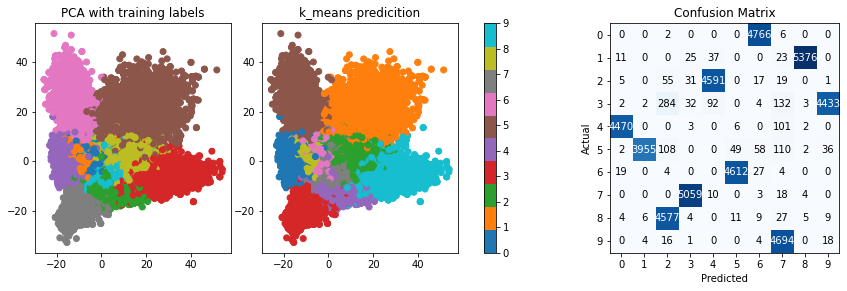

In [ ]:
plot_PCA(f_space['block1.5'], y_train)

## Convolutional neural networks

---

We now focus on the classification of the MNIST dataset with convolutional neural networks.

### The network
--- 
We construct a CNN with 3 convolutional layers (each of them accompanied by max Pooling layer) and two fully connected neural networks.


In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, 3), # 1 input channel, 16 output channels (or filters), 3 kernel size (3x3)
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.Flatten())
        self.block2 = nn.Sequential(
            nn.Linear(144, 128, bias=True), # why 144?
            nn.ReLU(),
            nn.Linear(128, 10, bias=True))


    def forward(self, xb):
        x = self.block1(xb)
        x = self.block2(x)
        return x

### Training with fastai
---

In [ ]:
loss = CrossEntropyLossFlat()
# folder_path = '/content/drive/My Drive/fastai/'
# # Create folder
# os.makedirs(folder_path, exist_ok=True)

log_name = folder_path + 'history_cnn.csv'
fname = folder_path + 'cnn'
callbacks = [ShowGraphCallback(),CSVLogger(fname=log_name,append=True)]
learn_cnn = Learner(loaders, Mnist_CNN(),loss_func=loss,opt_func=Adam,metrics=accuracy,cbs=callbacks)
learn_cnn.model.cuda()  # if colab does not allow you to use the GPU, comment this line as it will throw error otherwise

Mnist_CNN(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (block2): Sequential(
    (0): Linear(in_features=144, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
learn_cnn.summary() # Note the decrease in number of parameters compared with FCN

Mnist_CNN (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 16 x 26 x 26   
Conv2d                                    160        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 13 x 13   
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 11 x 11   
Conv2d                                    2320       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 5 x 5     
MaxPool2d                                                      
____________________________________________________________________________
                     64 x 16 x 3 x

epoch,train_loss,valid_loss,accuracy,time
0,0.153993,0.129695,0.958833,00:49
1,0.095779,0.083614,0.973750,00:49
2,0.069053,0.077838,0.975667,00:49
3,0.051572,0.052157,0.983833,00:49
4,0.049471,0.051887,0.983750,00:49
5,0.033075,0.047836,0.985833,00:50
6,0.027809,0.047465,0.985917,00:50
7,0.027755,0.036314,0.988833,00:50
8,0.032227,0.043323,0.986250,00:50
9,0.028560,0.054496,0.983833,00:51


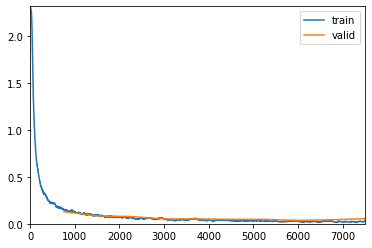

Path('/content/drive/My Drive/fastai/cnn.pth')

In [ ]:
learn_cnn.fit(10)
learn_cnn.save(fname)

In [ ]:
learn_cnn.load(fname)

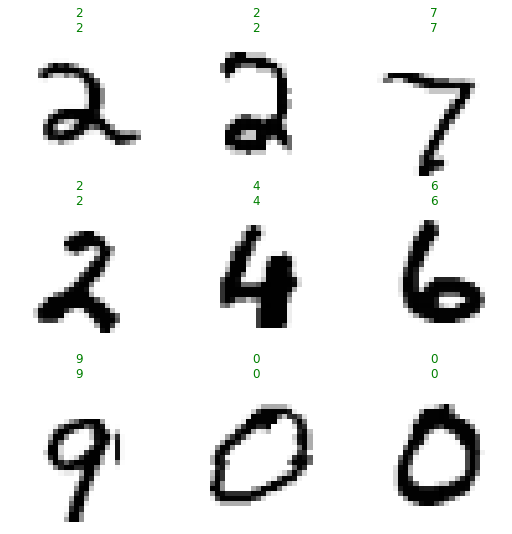

In [ ]:
learn_cnn.show_results()

In [ ]:
df = pd.read_csv(log_name)
df.head()

,epoch,train_loss,valid_loss,accuracy,time
0,0,0.153993,0.129695,0.958833,00:49
1,1,0.095779,0.083614,0.973750,00:49
2,2,0.069053,0.077838,0.975667,00:49
3,3,0.051572,0.052157,0.983833,00:49
4,4,0.049471,0.051887,0.983750,00:49


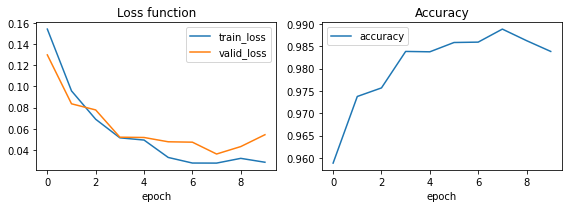

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
df.plot(x='epoch',y=['train_loss','valid_loss'],ax=ax[0])
df.plot(x='epoch',y='accuracy',ax=ax[1])
title = ['Loss function','Accuracy']
for i in range(2):
  ax[i].set_title(title[i])
plt.tight_layout()

### Inspection of the trained neural network
---

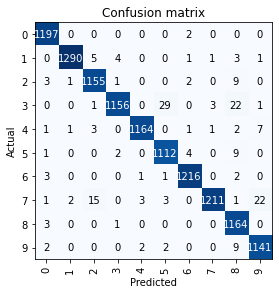

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_cnn)
interp.plot_confusion_matrix()

In [ ]:
dl = learn_cnn.dls[0]
xx = learn_cnn.get_preds(dl=dl,with_loss=True,with_input=True)
input,y_pred,y,ll = xx[0],xx[1],xx[2],xx[3]
y_pred = torch.argmax(y_pred,dim=1)
mask = torch.argsort(ll)

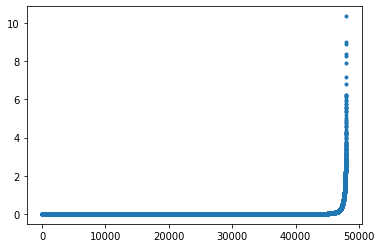

In [ ]:
plt.plot(ll[mask],'.');

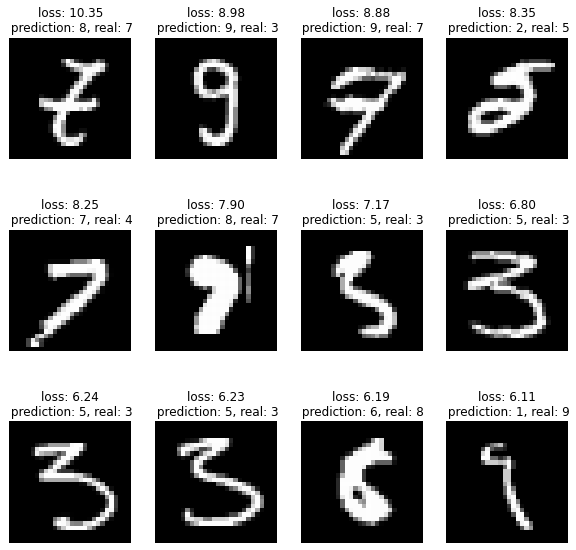

In [ ]:
# We take 12 examples in the training set
nexample = 12

fig,axes = plt.subplots(nrows=nexample//4,ncols=4,figsize=(10,10))

for i,ax in enumerate(axes.flat):
  index = mask[-i-1]
  ax.imshow(input[index][0,:,:],cmap='gray')
  ax.set_title(f'loss: {ll[index]:.2f}\n prediction: {y_pred[index]}, real: {y[index]}')
  ax.axis('off')

In [ ]:
cleaner = ImageClassifierCleaner(learn_cnn)
cleaner

### Analysis of the feature space
---

In [ ]:
f_space, y_train = feature_space(learn_cnn.model,loaders.train,['block2.1'])

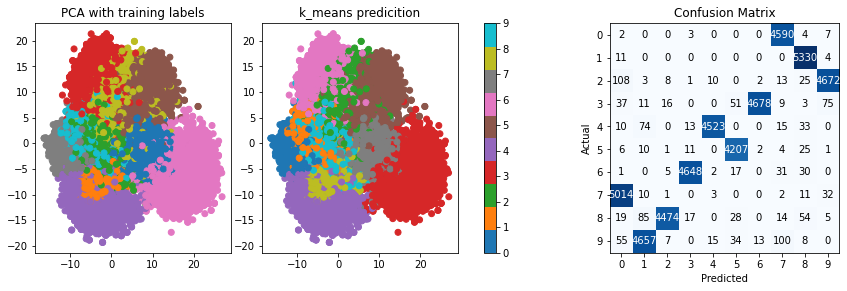

In [ ]:
plot_PCA(f_space['block2.1'], y_train)

##Batch Normalization
---
We then probe the same model but with a batch normalization layer after each convolutional layer.

In [ ]:
class Mnist_CNN_batch(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten())
        self.block2 = nn.Sequential(
            nn.Linear(144, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 10, bias=True))


    def forward(self, xb):
        x = self.block1(xb)
        x = self.block2(x)
        return x

In [ ]:
loss = CrossEntropyLossFlat()
# folder_path = '/content/drive/My Drive/fastai/'
# # Create folder
# os.makedirs(folder_path, exist_ok=True)

log_name = folder_path + 'history_cnn_batch.csv'
fname = folder_path + 'cnn_batch'
callbacks = [ShowGraphCallback(),CSVLogger(fname=log_name,append=True)]
learn_cnn_batch = Learner(loaders, Mnist_CNN_batch(),loss_func=loss,opt_func=Adam,metrics=accuracy,cbs=callbacks)
learn_cnn_batch.model.cuda() # if colab does not allow you to use the GPU, comment this line as it will throw error otherwise

Mnist_CNN_batch(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (block2): Sequential(
    (0): Linear(in_features=144, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

epoch,train_loss,valid_loss,accuracy,time
0,0.057400,0.060519,0.981000,00:51
1,0.050857,0.063400,0.980500,00:51
2,0.047907,0.048633,0.984500,00:51
3,0.025515,0.037893,0.988167,00:51
4,0.027562,0.051605,0.984083,00:52
5,0.021545,0.051935,0.983250,00:50
6,0.019767,0.038358,0.988750,00:51
7,0.017351,0.038221,0.988833,00:51
8,0.012252,0.037279,0.989000,00:51
9,0.017401,0.044610,0.988083,00:51


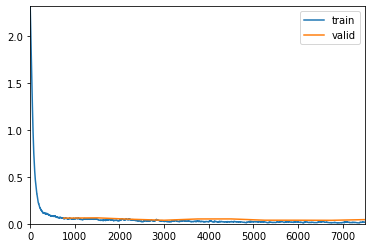

Path('/content/drive/My Drive/fastai/cnn_batch.pth')

In [ ]:
learn_cnn_batch.fit(10)
learn_cnn_batch.save(fname)

In [ ]:
learn_cnn_batch.load(fname)

In [ ]:
df = pd.read_csv(log_name)
df.head()

,epoch,train_loss,valid_loss,accuracy,time
0,0,0.057400,0.060519,0.981000,00:51
1,1,0.050857,0.063400,0.980500,00:51
2,2,0.047907,0.048633,0.984500,00:51
3,3,0.025515,0.037893,0.988167,00:51
4,4,0.027562,0.051605,0.984083,00:52


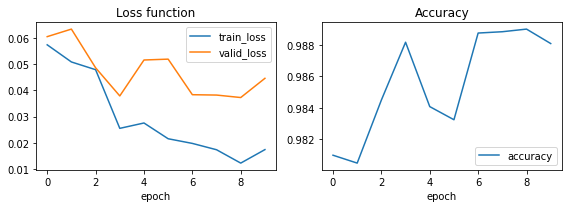

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
df.plot(x='epoch',y=['train_loss','valid_loss'],ax=ax[0])
df.plot(x='epoch',y='accuracy',ax=ax[1])
title = ['Loss function','Accuracy']
for i in range(2):
  ax[i].set_title(title[i])
plt.tight_layout()

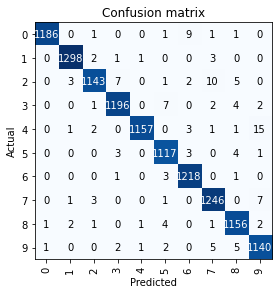

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_cnn_batch)
interp.plot_confusion_matrix()

In [ ]:
dl = learn_cnn_batch.dls[0]
xx = learn_cnn_batch.get_preds(dl=dl,with_loss=True,with_input=True)
input,y_pred,y,ll = xx[0],xx[1],xx[2],xx[3]
y_pred = torch.argmax(y_pred,dim=1)
mask = torch.argsort(ll)

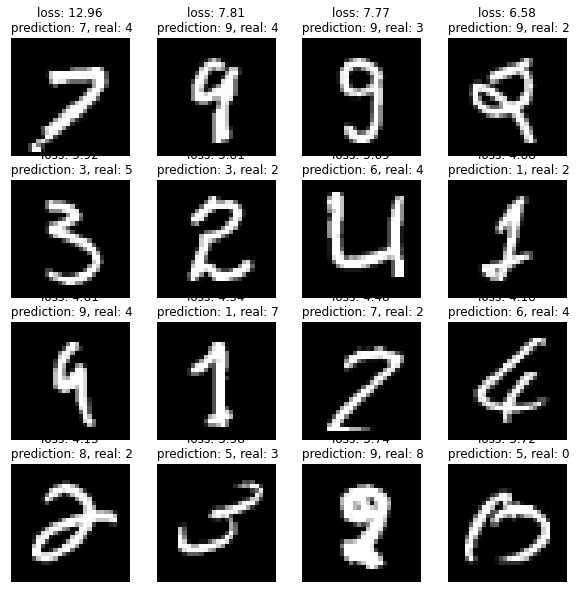

In [ ]:
# We take 12 examples in the training set
nexample = 12

fig,axes = plt.subplots(nrows=nexample//4+1,ncols=4,figsize=(10,10))

for i,ax in enumerate(axes.flat):
  index = mask[-i-1]
  ax.imshow(input[index][0,:,:],cmap='gray')
  ax.set_title(f'loss: {ll[index]:.2f}\n prediction: {y_pred[index]}, real: {y[index]}')
  ax.axis('off')

In [ ]:
f_space, y_train = feature_space(learn_cnn_batch.model,loaders.train,['block2.1'])

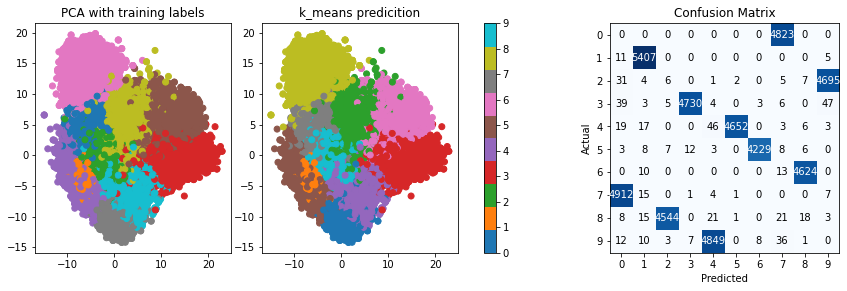

In [ ]:
plot_PCA(f_space['block2.1'], y_train)

##Convolutional filters
---


Let's now look at the effect of the convolutional filters on the image. We first inspect the model. The layers will typically have name of the form `blockx.y` .

In [ ]:
learn_cnn_batch.model

Mnist_CNN_batch(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (block2): Sequential(
    (0): Linear(in_features=144, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
f_space, y_train, x_train = feature_space(learn_cnn_batch.model,loaders.train,['block1.2','block1.6'],iters=40,original=True)

Let's now have a look at the effect of the filters.

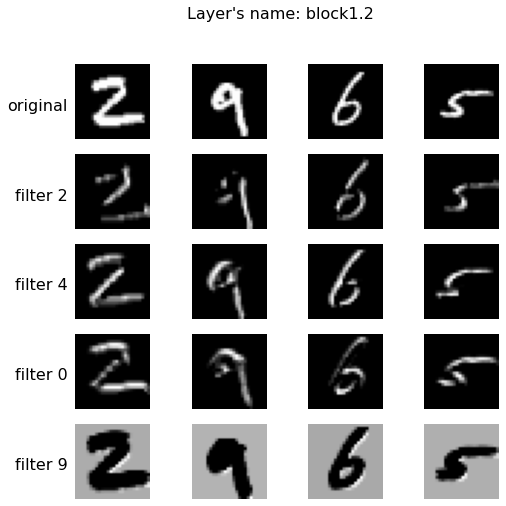

In [ ]:
# We take 4 examples in the training set
nexample = 4
key = 'block1.2'
n_filters = 4
n_training = f_space[list(f_space.keys())[0]].shape[0]

fig,axes=plt.subplots(nrows=n_filters+1,ncols=4,figsize=(nexample*2,n_filters*2))

num_im = np.random.choice(range(n_training), nexample, replace=False)
num_filters = np.random.choice(range(f_space[key].shape[1]), n_filters, replace=False)

fig.suptitle(f"Layer's name: {key}",fontsize=16)

for i in range(n_filters+1):

  for j in range(nexample):
    ax = axes[i,j]
    if i ==0:
      im = x_train[num_im[j],0,:,:]
    else:
      im = f_space[key][num_im[j],num_filters[i-1],:,:]
    ax.imshow(im,cmap='gray')
    ax.axis('off')

for i in range(n_filters+1):
    title = 'original'if i == 0 else f'filter {num_filters[i-1]}'
    axes[i,0].text(-0.1, 0.55, title, transform=axes[i,0].transAxes,
      fontsize=16, va='top', ha='right')
# what do you see?
# what are theses filters representing?
# Interact with https://setosa.io/ev/image-kernels/

## Data augmentation
---

To avoid overfitting, people developed the data augmentation technique. 
In the latter, one generates from the training set new images that are transformed in some way: rotated, squeezed, translated, deformed...
These transformed images are then used as a bigger training set.

Examples of transformations:

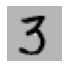

In [ ]:
list_path = (path/'training'/f'{3}').ls()
img = PILImageBW.create(random.choice(list_path))
timg = TensorImage(array(img)).float()/255.+0.4 
# we add some grey level to see the affine tranformations
timg[-14,-14] = 0 # for show_image to take zero as the minimum of the cmap

y = [timg[None][None]]
show_image(timg, cmap='gray_r');

In [ ]:
tfms = [Rotate(p=1.,draw=[-30], pad_mode='reflection'),
        Warp(p=1., draw_x=[0.5], draw_y=0., pad_mode='reflection'),
        Zoom(p=1., draw=1.5),
        ]
tfms_labels = ['Original']
tfms_labels+= [t.name.split(' ')[0] for t in tfms]
tfms_labels, tfms

(['Original', 'Rotate', 'Warp', 'Zoom'],
 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
  encodes: (TensorImage,object) -> encodes
  (TensorMask,object) -> encodes
  (TensorBBox,object) -> encodes
  (TensorPoint,object) -> encodes
  decodes: ,
  Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': [0.5], 'draw_y': 0.0, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
  encodes: (TensorImage,object) -> encodes
  (TensorMask,object) -> encodes
  (TensorBBox,object) -> encodes
  (TensorPoint,object) -> encodes
  decodes: ,
  Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
  encodes: (TensorImage,object) -> encodes
  (TensorMask,object) -> encodes
  (TensorBBox,object) -> encodes
  (TensorPoint,object) -> encodes
  decodes: ])

For more transforms see [fastai doc](https://docs.fast.ai/vision.augment.html).

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


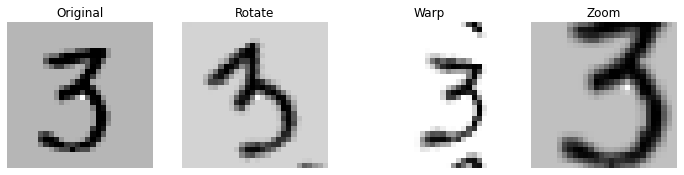

In [ ]:
y = [y[0]]
for t in tfms: y.append(t(timg[None][None], ))
_,axs = plt.subplots(1,len(y), figsize=(12,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i][0], ctx=ax, cmap='gray_r', title=tfms_labels[i])

The data augmentation is already implemented in fastai.
We only need to add `aug_transforms()` into the data loader we used in the begging and create a learner with this new loader.
This way, the images will be randomly transformed by a collection of functions selected by fastai that are meant to work well on many datasets.

In [ ]:
loaders = block.dataloaders(path/"training", batch_tfms=aug_transforms())

We can have a look at the different examples produced by the dataloader.

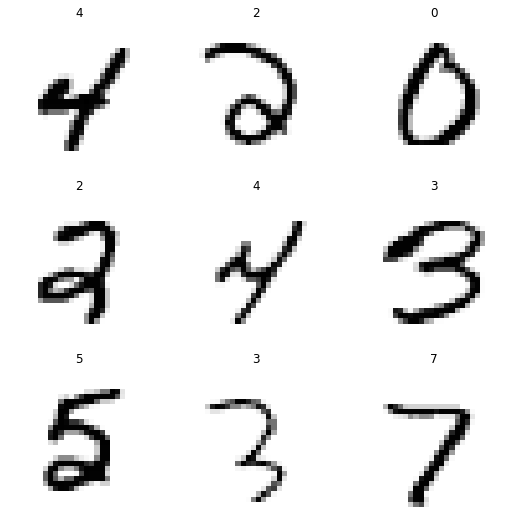

In [ ]:
loaders.show_batch()

Or explore what `aug_transforms()` does on one example.
This function groups affine transformations (flip, rotate, zoom, warp)  and the lighting transforms (brightness, contrast).

In [ ]:
tfms = aug_transforms(mult=2, p_affine=1, p_lighting=1, pad_mode='zeros',)
tfms

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'zeros', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.4, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

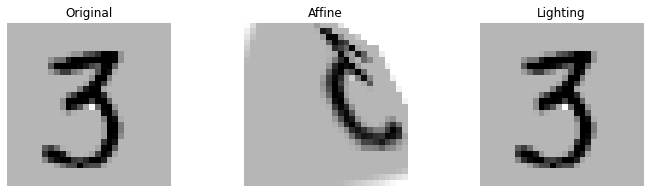

In [ ]:
y = [y[0]]
for t in tfms: y.append(t(timg[None][None]))
_,axs = plt.subplots(1,3, figsize=(12,3))
for i,ax in enumerate(axs.flatten()):
    show_image(y[i][0], ctx=ax, cmap='gray_r', title=['Original', 'Affine', 'Lighting'][i])

We now reuse the architecture in the previous chapter `Mnist_CNN_batch()`.

In [ ]:
loss = CrossEntropyLossFlat()
# folder_path = '/content/drive/My Drive/fastai/'
# # Create folder
# os.makedirs(folder_path, exist_ok=True)

log_name = folder_path + 'history_cnn_aug.csv'
fname = folder_path + 'cnn_aug'
callbacks = [ShowGraphCallback(),CSVLogger(fname=log_name,append=True)]
learn_cnn_aug = Learner(loaders, Mnist_CNN_batch(),loss_func=loss,opt_func=Adam,metrics=accuracy,cbs=callbacks)
learn_cnn_aug.model.cuda()

Mnist_CNN_batch(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (block2): Sequential(
    (0): Linear(in_features=144, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

epoch,train_loss,valid_loss,accuracy,time
0,0.065560,0.069109,0.977750,01:18
1,0.044738,0.051859,0.984417,01:21
2,0.035267,0.046362,0.986250,01:21
3,0.041470,0.052239,0.984083,01:20
4,0.032510,0.041847,0.987750,01:20
5,0.020834,0.038004,0.989250,01:19
6,0.024692,0.046529,0.986417,01:18
7,0.022520,0.042905,0.989000,01:19
8,0.019653,0.037454,0.990083,01:19
9,0.013924,0.040376,0.989833,01:21


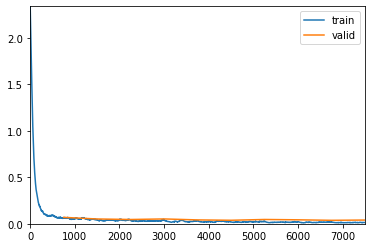

Path('models/cnn_aug.pth')

In [ ]:
learn_cnn_aug.fit(10)
learn_cnn_aug.save(fname)

In [ ]:
learn_cnn_aug.load(fname)

In [ ]:
df = pd.read_csv(log_name)
df.head()

,epoch,train_loss,valid_loss,accuracy,time
0,0,0.065560,0.069109,0.977750,01:18
1,1,0.044738,0.051859,0.984417,01:21
2,2,0.035267,0.046362,0.986250,01:21
3,3,0.041470,0.052239,0.984083,01:20
4,4,0.032510,0.041847,0.987750,01:20


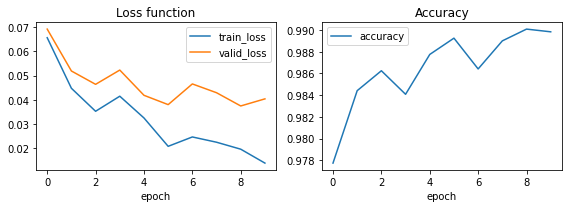

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
df.plot(x='epoch',y=['train_loss','valid_loss'],ax=ax[0])
df.plot(x='epoch',y='accuracy',ax=ax[1])
title = ['Loss function','Accuracy']
for i in range(2):
  ax[i].set_title(title[i])
plt.tight_layout()

When plotting the Loss function and the accuracy, we now see that we have prevented the model to overfit as the validation set oscillates around the training curve.

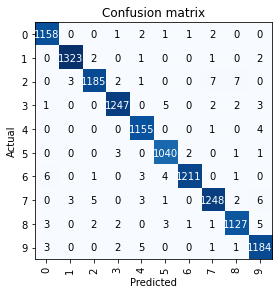

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_cnn_aug)
interp.plot_confusion_matrix()

## Transfer learning
---

The transfer learning is a pretty nice technique coming from convolutional neural networks. The idea is the following.
Take a professionally trained architecture such as VGG16, ResNet, or GoogLeNet on a huge database such as imagenet. 
This pretrained network already knows how to extract relevant features from the big and general dataset. 
This knowledge can be transferred to another problem.
To this end, one first freezes all the convolutional layers and train the classifier on the new dataset.
 Then, one performs fine tuning of the convolutional layers.


In this section, we will just freeze the convolutional layers and show that one can reach pretty decent score on the MNIST by training only the classifier and use the other layers as a feature extractor.

64

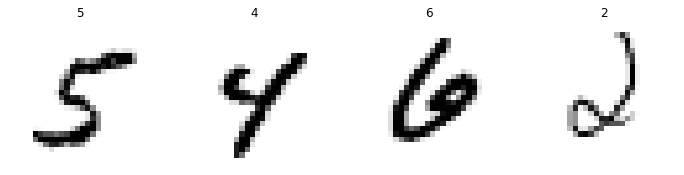

In [ ]:
block = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label)
loaders = block.dataloaders(path/"training")
loaders.train.show_batch(max_n=4, nrows=1)
loaders.bs

In [ ]:
loss = CrossEntropyLossFlat()
folder_path = '/content/drive/My Drive/fastai/'
# Create folder
os.makedirs(folder_path, exist_ok=True)

log_name = folder_path + 'history_transfer.csv'
fname = folder_path + 'transfer'
callbacks = [ShowGraphCallback(),CSVLogger(fname=log_name,append=True)]
learn_transfer = cnn_learner(loaders, resnet18, loss_func=loss,opt_func=Adam,metrics=accuracy,cbs=callbacks)
learn_transfer.model.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The data allowed by the pretrained model do actually not match with our training set. 
ResNet was trained on [ImageNet](https://www.image-net.org/), a huge dataset of RGB images (3 channels) and thousands of classes.
Indeed, the size of the ImageNet samples is (32,32,3). 
However, we are working with smaller grey images (28,28,1). 
To circumvent this problem, we could embed the MNIST images by adding zeros around and making three copies of the same image for the three layers.
While the later is what fastai does for the channel problem,
the former is handled with Adaptive pooling layers, thus, no need for padding.
See this question in fastai's [forum](https://forums.fast.ai/t/why-mnist-works-with-resnet-without-throwing-error/57855/11).


In [ ]:
learn_transfer.summary()

Sequential (Input shape: 64 x 3 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 14 x 14   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 7 x 7     
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                        

We can see how well the pretrained model does in our data.

In [ ]:
f_space, y_train = feature_space(learn_transfer.model,loaders.train,['1.1','1.2','1.4'],) # ~8 min.

The clusterization made in the last feature extractor layer (before the classifier) is expected to be better than in raw data.
However, we don't see better clusterization here. 
What could be happening?

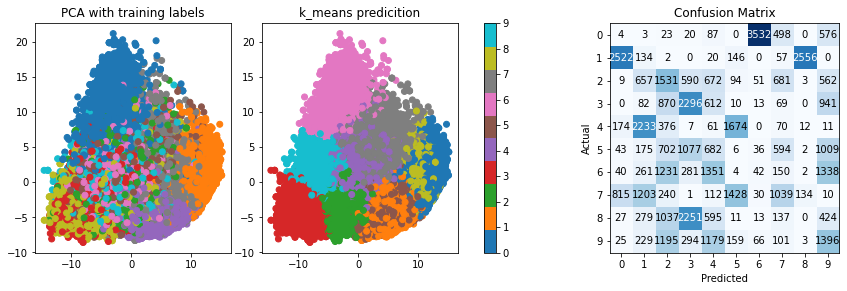

In [ ]:
plot_PCA(f_space['1.1'], y_train)

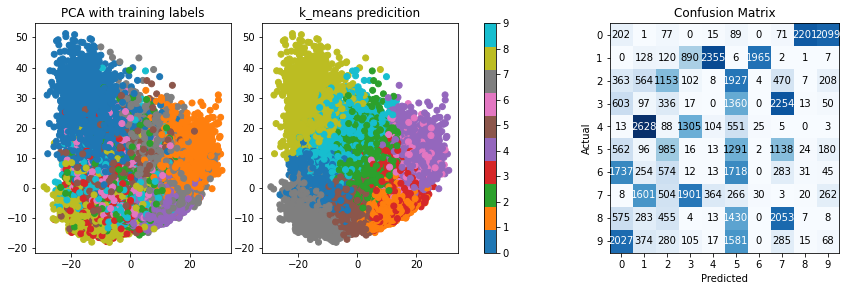

In [ ]:
plot_PCA(f_space['1.2'], y_train)

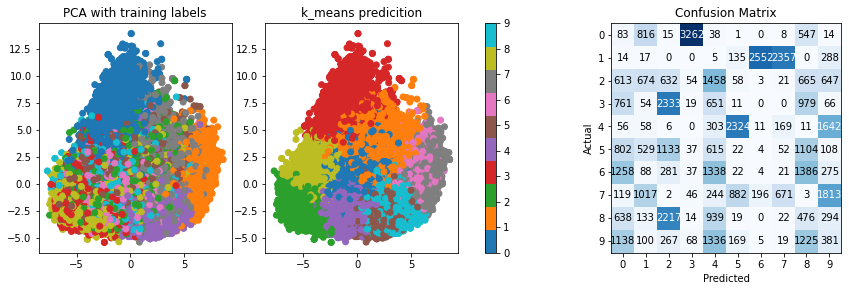

In [ ]:
plot_PCA(f_space['1.5'], y_train)

Let's fine tune the net.

epoch,train_loss,valid_loss,accuracy,time
0,1.152252,0.762623,0.765500,01:52
1,0.641815,0.433437,0.862000,01:51
2,0.381304,0.249191,0.921083,01:52


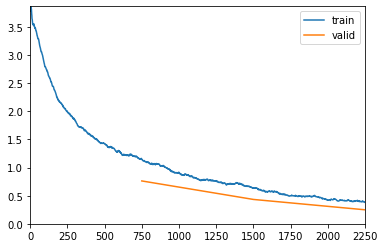

epoch,train_loss,valid_loss,accuracy,time
0,0.125456,0.071464,0.978500,02:02
1,0.105110,0.069814,0.980417,02:03
2,0.065464,0.047270,0.986583,02:00
3,0.034227,0.038076,0.989333,01:59
4,0.017489,0.035914,0.990667,01:53
5,0.011238,0.034638,0.991833,01:54


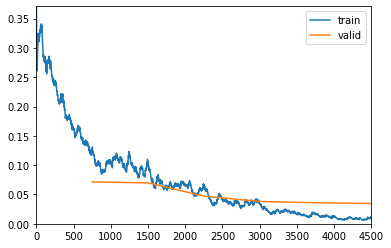

Path('models/transfer.pth')

In [ ]:
unfreezed_epochs = 6
learn_transfer.fine_tune(unfreezed_epochs, freeze_epochs=3,) # ~2 min./epoch
learn_transfer.save(fname)

# or (as in https://github.com/BorjaRequena/ML-for-quantum-and-classical-systems/blob/main/0%20Introduction%20to%20classical%20machine%20learning/00_computer_vision.ipynb)
# learn_transfer.freeze() # freezes up to the last set
# learn_transfer.fit_one_cycle(3, lr_max=1e-3, pct_start=0.99)
# learn_transfer.unfreeze()
# learn_transfer.fit_one_cycle(6, lr_max=slice(5e-6, 5e-4)) # Train first layers 100 times slower than last ones

The curve converges very fast thanks to the transfer learning. The history shows a bit of overfitting but this overfitting occurs at 99%! This can be improved by:


*   defreezing the convolutional layers and fine tuning the learning rate
*   combining data augmentation and transfer learning

In [ ]:
f_space, y_train = feature_space(learn_transfer.model,loaders.train,['1.5'],) # ~8 min.

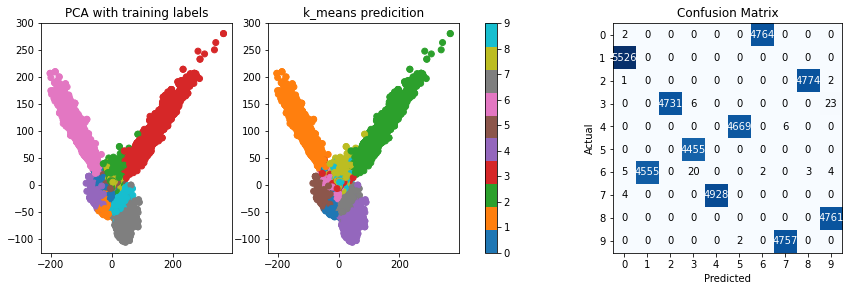

In [ ]:
plot_PCA(f_space['1.5'], y_train)

In [ ]:
learn_transfer.load(fname)

In [ ]:
df = pd.read_csv(log_name)
df#.head()

,epoch,train_loss,valid_loss,accuracy,time
0,0,None,None,00:00,NaN
1,epoch,train_loss,valid_loss,accuracy,time
2,0,1.1522516012191772,0.7626225352287292,0.765500009059906,01:52
3,1,0.6418148279190063,0.43343669176101685,0.8619999885559082,01:51
4,2,0.3813035786151886,0.24919143319129944,0.9210833311080933,01:52
5,epoch,train_loss,valid_loss,accuracy,time
6,0,0.12545596063137054,0.07146413624286652,0.9785000085830688,02:02
7,1,0.10511010885238647,0.06981353461742401,0.9804166555404663,02:03
8,2,0.06546418368816376,0.047269754111766815,0.9865833520889282,02:00
9,3,0.0342274084687233,0.03807583451271057,0.9893333315849304,01:59


In [ ]:
df = df.drop([0,1,5], axis=0) # drop text

In [ ]:
df = df.apply(pd.to_numeric, errors = 'coerce') # convert object types to numeric

In [ ]:
df = df.assign(epochs=list(range(3+6)))

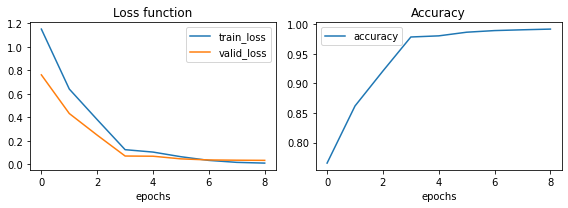

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
df.plot(x='epochs',y=['train_loss','valid_loss'],ax=ax[0])
df.plot(x='epochs',y='accuracy',ax=ax[1])
title = ['Loss function','Accuracy']
for i in range(2):
  ax[i].set_title(title[i])
plt.tight_layout()

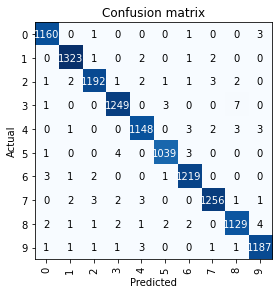

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_transfer)
interp.plot_confusion_matrix()

See this tutorial for more information:
https://docs.fast.ai/tutorial.vision.html